# Raggruppamento automatizzato di emendamenti simili del disegno di legge Cirinna

In questo elaborato vengono raggruppati e analizzati gli emendamenti simili
del disegno legge "cirinna" ed eliminate quelle superflue. 
Il disegno di legge Cirinna parla della regolamentazione delle unioni civili tra persone dello stesso sesso e disciplina delle convivenze.
Nell'ambito tecnico si inizia ad importare le librerie di python e si imposta la cartella "DATA_FOLDER" dove contiene tutti i file scaricati dal sito del senato "https://www.senato.it/leg/17/BGT/Schede/Ddliter/testi/46051_testi.htm" dove a sua volta contengono i gli articoli da raggruppare. 
Le funzioni NAMESPACE e ALPHANUM_REGEX servono per lo spazio dei nomi e per le espressioni regolari delle stringhe da estrapolare.

In [1]:
import os
import re
from itertools import combinations
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
%matplotlib inline

In [3]:
DATA_FOLDER = 'data/cirinna'
NAMESPACE = {'an': 'http://docs.oasis-open.org/legaldocml/ns/akn/3.0/CSD03'}
ALPHANUM_REGEX = re.compile('[\W+]', re.UNICODE)

Il problema che vogliamo risolvere è un clustering non supervisionato in un numero imprecisato di cluster. Il solito algoritmo utilizzato per risolverlo è una variazione del clustering gerarchico combinato con alcune euristiche per "tagliare" il dendrogramma risultante a una certa altezza per produrre i cluster previsti.
Tutte le variazioni del clustering gerarchico ci richiedono di definire una metrica di distanza tra gli elementi. Nel nostro caso, gli elementi sono testi liberi, quindi usiamo una distanza relativa a [Jaccard Similarity](https://en.wikipedia.org/wiki/Jaccard_index) sui token del testo, dove un _token_ è una stringa contigua di caratteri alfanumerici.

In [4]:
def to_tokens(s):
    return set(ALPHANUM_REGEX.sub(' ', s).lower().split())

La funzione "jaccard_distance" serve a stampare in una mappa i parametri del disegno di legge

In [5]:
def jaccard_distance(x, y):    
    return 1 - (len(x['tokens'] & y['tokens']) / len(x['tokens'] | y['tokens']))

Usando i dati XML scaricati dallo spider Scrapy, costruiamo un array chiamato `emendamenti`.
Ogni elemento dell'array è un dizionario la cui struttura è esemplificata dal seguente:
```python
{
    '_id': '1.100',
    'authors': ['SACCONI', "D'ASCOLA", 'AIELLO', 'ALBERTINI', ..., 'DI BIAGIO'],
    'raw': 'Sopprimere gli articoli da 1 a 10.',
    'tokens': set(['1', '10', 'a', 'articoli', 'da', 'gli', 'sopprimere'])
}
```

In [6]:
amendments = []

for filename in sorted(os.listdir(DATA_FOLDER)):
    if filename.startswith('.'):
        continue

    tree = ET.parse(os.path.join(DATA_FOLDER, filename))

    _id = tree.find('.//an:FRBRnumber', NAMESPACE).get('value')
    authors = [el.text for el in tree.findall('.//an:docProponent', NAMESPACE)]
    raw = ' '.join(tree.find('.//an:amendmentContent', NAMESPACE).itertext())
    tokens = to_tokens(raw)

    amendments.append({'_id': _id, 'authors': authors, 'raw': raw, 'tokens': tokens})

Come prova, si stampano i primi 200 emendamenti

In [7]:
first_amendments = amendments[:200]
first_distances = [jaccard_distance(x, y) for x, y in combinations(first_amendments, 2)]

Ora calcoliamo un raggruppamento gerarchico su questi duecento elementi e visualizziamo i risultati come un dendrogramma. Nel caso non ci sono emendamenti si restituisce una stringa "Vuoto!, non ci sono emendamenti in merito"

In [8]:
#Z_first = linkage(first_distances, method='complete')
if (len(first_distances)!=0):
    Z_first = linkage(first_distances, method='complete')
else: 
    print("Vuoto!, non ci sono emendamenti in merito")

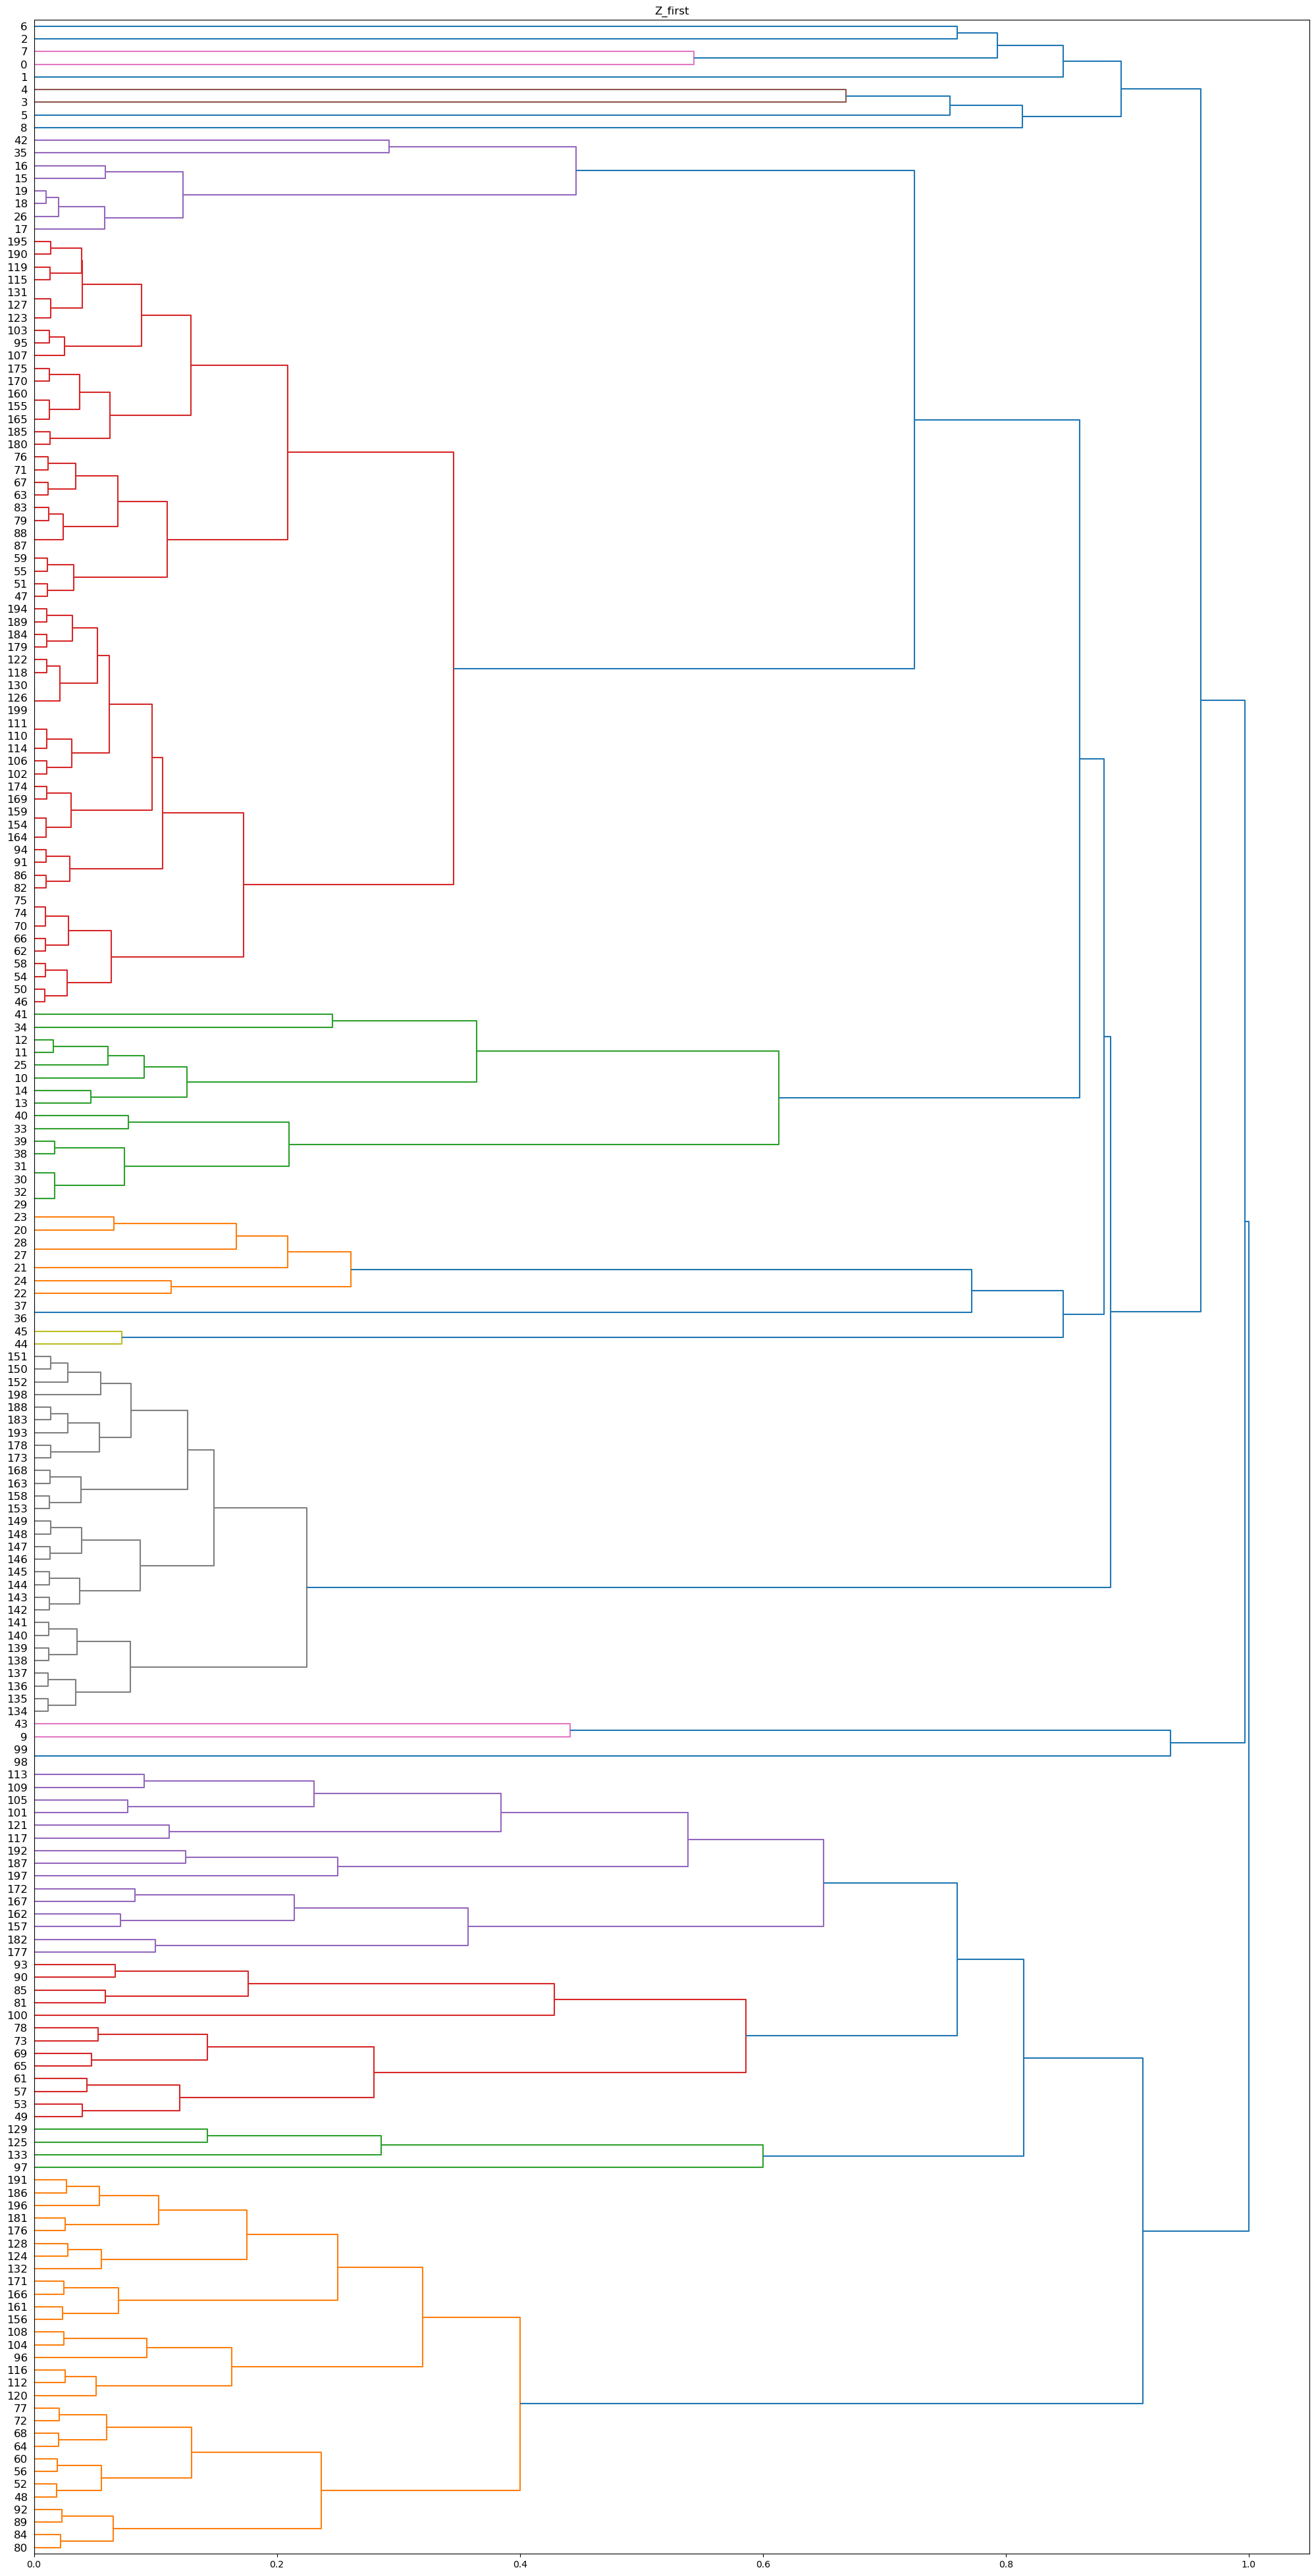

In [9]:
plt.figure(figsize=(25, 50))
plt.title('Z_first')
dendrogram(
    Z_first,
    orientation='right',
    leaf_font_size=12.,
)
plt.show()

Sembra che l'algoritmo abbia trovato diversi cluster, evidenziati da colori diversi. Analizziamo l'ultimo:

In [10]:
for i in [77, 72, 68, 64, 60, 56, 52, 48, 92, 89, 84, 80, 96]:
    print('{i}: {snippet}'.format(i=i, snippet=first_amendments[i]['raw'][:76]))

77: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15. C
72: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
68: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
64: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
60: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
56: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
52: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
48: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
92: Sopprimere gli articoli 1, 2, 3, 4, S, 6, 7, 8, 9, 10, 11. Conseguentemente,
89: Sopprimere gli articoli 1, 2, 3,4, S, 6, 7, 8, 9, 10, 11, 12. Conseguentemen
84: Sopprimere gli articoli 1, 2, 3, 4, S, 6, 7, 8, 9, 10, 11, 12, 13. Conseguen
80: Sopprimere gli articoli 1, 2, 3, 4, S, 6, 7, 8, 9, 10, 11, 12, 13, 14. Conse
96: Sopprimere gli articoli 

A questo punto l'idea è di stampare gli emendamenti analizzati in un file json per creare una API, quindi mi limito a stampare nel file "EmendamentiCirinna.json" e salvarlo nella cartella locale

In [11]:
import json
nameFile = "EmendamentiCirinna.json"
#print(first_amendments)
data_str = json.dumps(first_amendments, default=lambda x: list(x) if isinstance(x, set) else x)
# Writing to sample.json

with open(nameFile, "w") as outfile:
    outfile.write(data_str)

Vediamo che, in effetti, tutti gli emendamenti di questo gruppo sono variazioni di uno solo.
Proviamo ora con il penultimo cluster:

In [12]:
for i in [78, 73, 69, 65, 61, 57, 53, 49, 93, 90, 85, 81]:
    print('{i}: {snippet}'.format(i=i, snippet=first_amendments[i]['raw'][:76]))

78: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15.
73: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
69: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
65: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
61: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
57: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
53: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
49: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1
93: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11.
90: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.
85: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13.
81: Sopprimere gli articoli 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14.


Ancora una volta, tutti gli emendamenti in questo gruppo sono variazioni di uno solo. Inoltre, differiscono dal cluster precedente per l'aggiunta dell'ultima frase, motivo per cui l'algoritmo di clustering gerarchico finirà per unire i due cluster.
Per ricontrollare, proviamo con gli emendamenti `6` e `97`, che non fanno parte dello stesso gruppo:

In [13]:
for i in [6, 97]:
    print('{i}: {snippet}'.format(i=i, snippet=first_amendments[i]['raw'][:76]))

6: Il Senato,             esaminato il disegno di legge n. 2081 contenente «Reg
97: Sopprimere gli articoli da 1 a 10.


Sembra che, in effetti, il testo di questi due emendamenti sia significativamente diverso.
Infine, eseguiamo l'algoritmo su tutti gli emendamenti contemporaneamente.

In [14]:
distances = [jaccard_distance(x, y) for x, y in combinations(amendments, 2)]

In [15]:
Z_all = linkage(distances, method='complete')

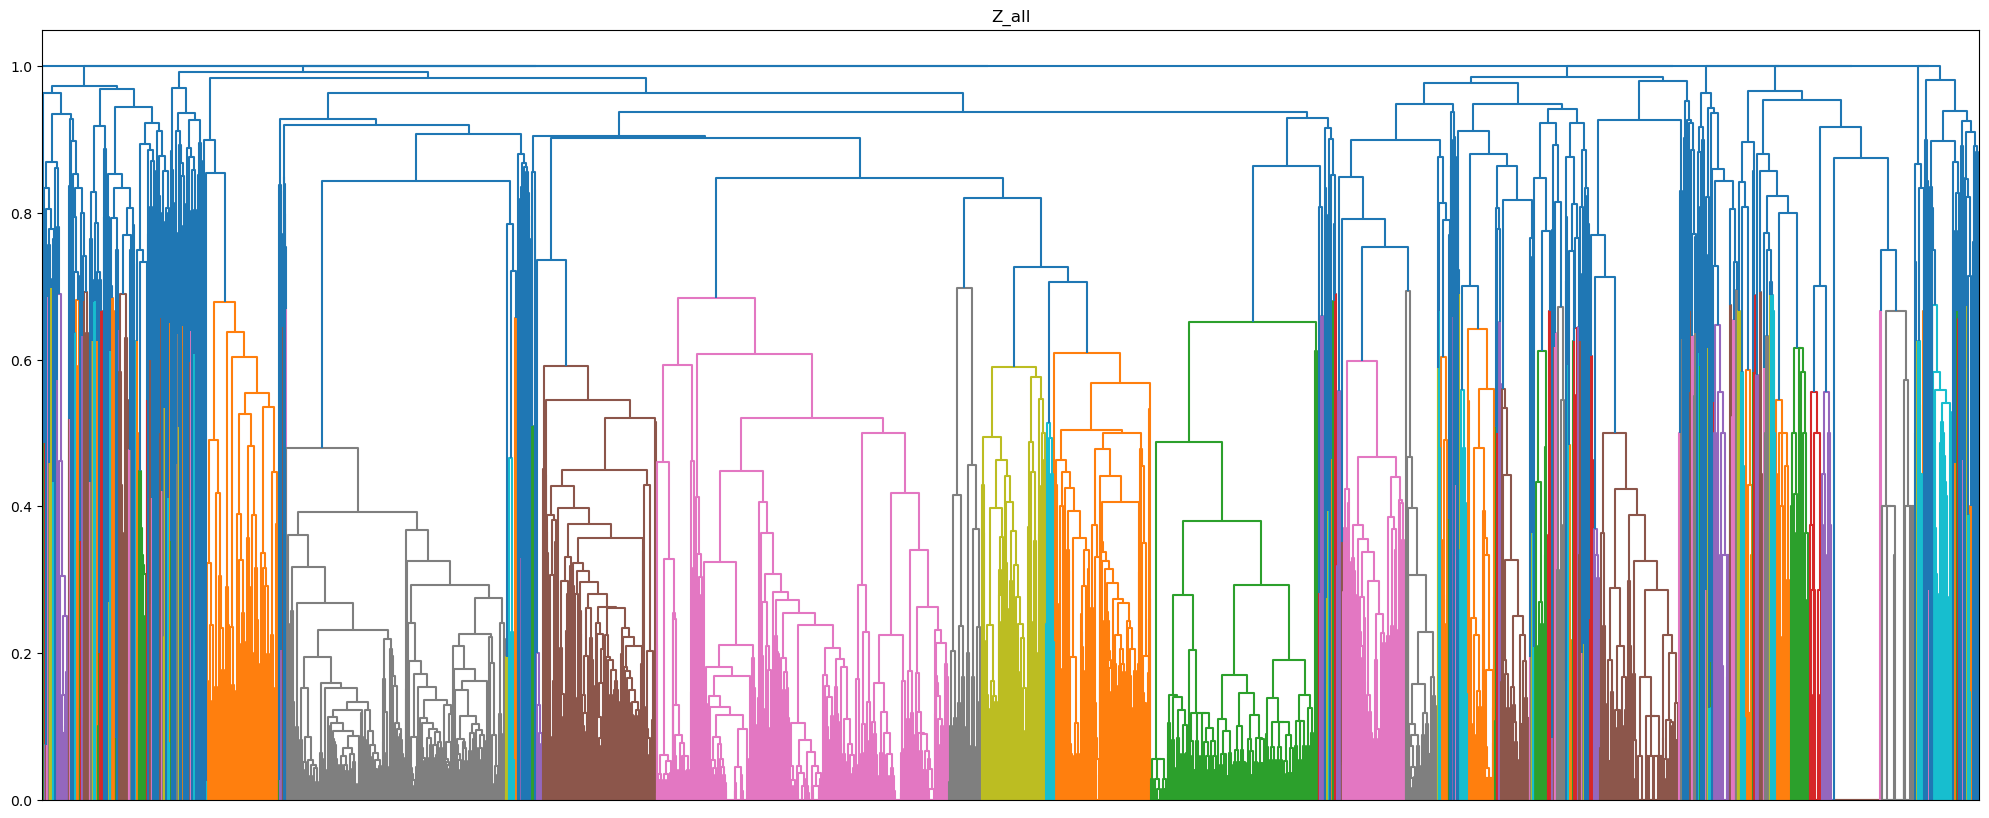

In [18]:
plt.figure(figsize=(25, 10))
plt.title('Z_all')
dendrogram(
    Z_all,
    no_labels=True,
)
plt.savefig('images/figuraCirinna.png') 
plt.show()
plt.close()

Osserviamo diversi cluster interessanti e notiamo che l'algoritmo può essere applicato a diverse migliaia di modifiche in un paio di minuti.